#  Multi-Category Classification to Identify Japanese Katakana Character

## Introduction
In this project, we apply data mining techniques to the classical machine learning problem of hand-written & machine printed character recognition. Language with a smaller alphabet is preferred to keep the training cycle short. So we choose a handwritten database of Japanese katakana for higher application value.


## Data Collection
Our dataset is taken from the ETL character database that can be found here: http://etlcdb.db.aist.go.jp/

We will be using the ETL-5 provided dataset that consists of 51 Katakana characters.

We have found that the hand-written images are of size 72x76 pixels, however there was a large amount of white space margin, therefore we have decided to crop the margin of every image down to 50x50 pixels.

During data elicitation, we have found that there were 3 duplicate characters that appeared twice, which will cause our classifier to classify one to another. These duplicate characters will also have twice the amount of data instances, and would be inconsistent with other characters, therefore we as a group have decided to remove the duplicates of these 3 characters, reducing our dataset to now consist 48 number of Katakana characters.

In [1]:
# !pip install numpy
# !pip install matplotlib
# !pip install sklearn

In [75]:
import struct
import numpy as np
from matplotlib import pyplot as plt
import math
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron

## Data Preprocessing and Visualization
To obtain the information from the ETLC-5 file, we use the following helper functions. 


### read_record()
The read_record() function will return an array of 4 bit color representation of a hand-written instance.
TODO: May need to elaborate more, I don't know how the helper function works.

In [78]:
# An instance record has 2952 bytes. (1 byte = 8 bits) (1 character = 6bits) (4bit/pixel) 
# 72(X-axis size) * 76(Y-axis size) = 5472 pixels
size_record = 2952

#Pixels will contain an array of the 4 bit color representation of a hand-written instance
def read_record(f):
    pixels = []
    s = f.read(size_record)
    str_data = struct.unpack_from('>2736s',s,216)[0]
    # print(str_data)
    offset = 0
    while offset < len(str_data):
        # Take the 6 bits, [2:] removes the 0b at the front, zfill appends zeros at the front to make to 8 bits
        byte = bin(int(str_data[offset]))[2:].zfill(8)
        
        # Append to pixels array
        pixels.append(byte[0:4])
        pixels.append(byte[4:8])
        offset = offset + 1
    pixels = [float(x) for x in pixels]
    return pixels

# with open('ETL5C', 'rb') as f:
#    print(len(np.array(read_record(f))))
#    for x in np.array(read_record(f)):
#        pass
        # print(str(int(x)).zfill(4))
    

### read_katakana()
The read_katakana() function will return a 4d array with values of 4 bit color representation of the form of arr[Char No, Instance No, X, Y]

In [89]:
def read_katakana():
    # 48: number of katakana characters
    # 208: number of images for each katakana
    # 50*50: image size
    arr = np.zeros([48,208,50,50], dtype=np.float32)
    filename = 'ETL5C'
    with open(filename, 'rb') as f:
        i = 0
        char_offset = 0
        while i < 10608:
        # for i in range(500):
            pixels_arr = np.array(read_record(f))
            pic = np.reshape(pixels_arr,(76,72)).astype(np.float32)
            
            # Crop image to 50px,50px
            pic = pic[13:63,11:61]
            # print(pic)
            
            # Remove characters number 36, 38, 47 since they are duplicates
            if math.floor(i/208) in [36,38,47]:
                if i in [36*208, 38*208, 47*208]:
                    char_offset = char_offset + 1
                i = i + 1
                continue
            # print("{} {}".format(math.floor(i/208), char_offset))
            arr[math.floor(i/208)-char_offset,i%208]= pic
            i = i + 1
    return arr

arr = read_katakana()

### Viewing the image using plt.imshow
As shown below, read_katakana() returns a 4d array, the array will be in the form of arr[Char No, Instance No, x, y].

We use plt.imshow with argument arr[0][0] to print the image of the 1st character and the 1st instance.

0100 finished.


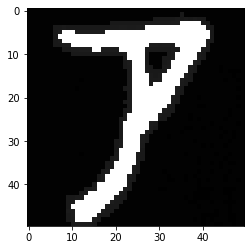

In [90]:
def view_image(arr,idx):
    plt.imshow(arr[0][0], cmap='gray', interpolation='nearest')
    # plt.savefig("pic{:04d}.png".format(idx)) #save image as file
    print("{:04d} finished.".format(idx))

view_image(arr,100)

## Data Mining
Now that we have all the hand-written instances stored conveniently in an array given by the read_katakana() function, we can start the data mining process using the algorithms we have learnt.

We define the functions of the algorithms that we are going to use.

In [91]:
def linearSVC(X,y,Xte,yte):
    print("Processing LinearSVC...")
    clf = LinearSVC(max_iter=2000)
    clf.fit(X, y)
    Xte_res = clf.predict(Xte)
    comp(Xte_res,yte)

def logisticReg(X,y,Xte,yte):
    print("Processing Logistic Regression...")
    logreg = LogisticRegression()
    logreg.fit(X, y)
    Xte_res = logreg.predict(Xte)
    comp(Xte_res,yte)

def naiveBayes(X,y,Xte,yte):
    print("Processing Gaussian Native Bayes...")
    nb = GaussianNB()
    nb.fit(X, y)
    Xte_res = nb.predict(Xte)
    comp(Xte_res,yte)

def kNeighbour(X,y,Xte,yte):
    print("Processing KNeighbour...")
    knn = KNeighborsClassifier()
    knn.fit(X, y)
    Xte_res = knn.predict(Xte)
    comp(Xte_res,yte)

def decisionTree(X,y,Xte,yte):
    print("Processing Decision Tree...")
    tree = DecisionTreeClassifier()
    tree.fit(X, y)
    Xte_res = tree.predict(Xte)
    comp(Xte_res,yte)

def perceptron(X,y,Xte,yte):
    print("Processing Perceptron...")
    percep = Perceptron()
    percep.fit(X, y)
    Xte_res = percep.predict(Xte)
    comp(Xte_res,yte)
    
def comp(Xte_res,yte):
    
    global char_offset
    
    match_num = 0
    match_list = np.zeros(48)
    
    for i in range(len(Xte_res)):
        if Xte_res[i] == yte[i]:
            match_list[int(yte[i])] = match_list[int(yte[i])] + 1
            match_num = match_num + 1
        print("{} ------ {}".format(yte[i],Xte_res[i]))
    
                          
    for i in range(len(match_list)):
        print("Character = {}, Correct = {}, % = {}".format(i, match_list[i], (match_list[i]/10)* 100))
    
    print("All {} test samples, {} matches. Predict rate is {}.".format(len(yte),match_num,match_num/len(yte)))   

In [92]:
def training(arr, classifier):
    # prepare X and y
    train_sz = 198
    test_sz = 10
    X = np.zeros([train_sz*48, 50*50], dtype=np.float32)
    Xte = np.zeros([test_sz*48, 50*50], dtype=np.float32)

    # get training matrix X, training label y, testing matrix Xte, testing label yte
    for i in range(48):
         train_pics = arr[i,0:train_sz,:,:]
         train_tuples = np.reshape(train_pics,(train_sz,50*50))
         X[i*train_sz:(i+1)*train_sz , :] = train_tuples

         test_pics = arr[i,train_sz:train_sz+test_sz,:,:]
         test_tuples = np.reshape(test_pics,(test_sz,50*50))
         Xte[i*test_sz:(i+1)*test_sz,:] = test_tuples

    y = np.zeros([train_sz*48])
    yte = np.zeros([test_sz*48])

    for i in range(train_sz*48):
        y[i] = math.floor(i/train_sz)

    for i in range(test_sz*48):
        yte[i] = math.floor(i/test_sz)
    if (classifier == 0):
        kNeighbour(X,y,Xte,yte)
    elif (classifier == 1):
        linearSVC(X,y,Xte,yte)
    elif (classifier == 2):
        logisticReg(X,y,Xte,yte)
    elif (classifier == 3):
        naiveBayes(X,y,Xte,yte)
    elif (classifier == 4):
        decisionTree(X,y,Xte,yte)
    elif (classifier == 5):
        perceptron(X,y,Xte,yte)

### Results for KNeighbour

In [93]:
training(arr,0) #KNeighbour

Processing KNeighbour...
0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 18.0
0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 7.0
0.0 ------ 0.0
0.0 ------ 20.0
0.0 ------ 0.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 0.0
1.0 ------ 1.0
1.0 ------ 17.0
1.0 ------ 1.0
2.0 ------ 2.0
2.0 ------ 27.0
2.0 ------ 18.0
2.0 ------ 43.0
2.0 ------ 43.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 38.0
2.0 ------ 17.0
2.0 ------ 7.0
3.0 ------ 3.0
3.0 ------ 3.0
3.0 ------ 3.0
3.0 ------ 3.0
3.0 ------ 36.0
3.0 ------ 3.0
3.0 ------ 3.0
3.0 ------ 3.0
3.0 ------ 18.0
3.0 ------ 29.0
4.0 ------ 4.0
4.0 ------ 33.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 37.0
4.0 ------ 24.0
5.0 ------ 5.0
5.0 ------ 24.0
5.0 ------ 24.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 24.0
5.0 ------ 7.0
5.0 ------ 7.0
6.0 ------ 6.0
6.0 ------ 6.0
6.0 ------ 6.0
6.0 ------ 6

### Results for Linear Regression

In [94]:
training(arr,1) #Linear Regression

Processing LinearSVC...
0.0 ------ 7.0
0.0 ------ 0.0
0.0 ------ 46.0
0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 9.0
0.0 ------ 30.0
0.0 ------ 4.0
0.0 ------ 46.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 46.0
1.0 ------ 1.0
1.0 ------ 10.0
1.0 ------ 18.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 5.0
2.0 ------ 5.0
2.0 ------ 27.0
2.0 ------ 7.0
3.0 ------ 45.0
3.0 ------ 45.0
3.0 ------ 45.0
3.0 ------ 34.0
3.0 ------ 36.0
3.0 ------ 3.0
3.0 ------ 3.0
3.0 ------ 3.0
3.0 ------ 45.0
3.0 ------ 3.0
4.0 ------ 4.0
4.0 ------ 37.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 33.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 23.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 37.0
5.0 ------ 29.0
5.0 ------ 5.0
6.0 ------ 16.0
6.0 ------ 6.0
6.0 ------ 6.0
6.0 ------ 6

### Results for NaiveBayes

In [95]:
training(arr,3) #NaiveBayes

Processing Gaussian Native Bayes...
0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 27.0
0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 27.0
0.0 ------ 27.0
0.0 ------ 0.0
0.0 ------ 0.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 43.0
2.0 ------ 43.0
2.0 ------ 43.0
2.0 ------ 2.0
2.0 ------ 30.0
2.0 ------ 27.0
2.0 ------ 18.0
3.0 ------ 45.0
3.0 ------ 45.0
3.0 ------ 21.0
3.0 ------ 21.0
3.0 ------ 44.0
3.0 ------ 33.0
3.0 ------ 21.0
3.0 ------ 21.0
3.0 ------ 21.0
3.0 ------ 21.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 12.0
4.0 ------ 12.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 33.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 27.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 31.0
5.0 ------ 31.0
5.0 ------ 5.0
5.0 ------ 31.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 25.0
6.0 ------ 44.0
6.0 ------ 34.0
6.0 -

### Results for Decision Tree

In [96]:
training(arr,4) #DecisionTree

Processing Decision Tree...
0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 45.0
0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 27.0
0.0 ------ 30.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 39.0
2.0 ------ 7.0
2.0 ------ 2.0
2.0 ------ 11.0
2.0 ------ 7.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 28.0
2.0 ------ 2.0
2.0 ------ 43.0
2.0 ------ 46.0
3.0 ------ 33.0
3.0 ------ 33.0
3.0 ------ 3.0
3.0 ------ 3.0
3.0 ------ 36.0
3.0 ------ 3.0
3.0 ------ 36.0
3.0 ------ 3.0
3.0 ------ 45.0
3.0 ------ 3.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 12.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 38.0
4.0 ------ 4.0
4.0 ------ 46.0
4.0 ------ 4.0
5.0 ------ 7.0
5.0 ------ 5.0
5.0 ------ 12.0
5.0 ------ 27.0
5.0 ------ 5.0
5.0 ------ 12.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 5.0
6.0 ------ 6.0
6.0 ------ 46.0
6.0 ------ 29.0
6.0 --

### Results for Perceptron

In [97]:
training(arr,5) #Perceptron

Processing Perceptron...
0.0 ------ 7.0
0.0 ------ 0.0
0.0 ------ 46.0
0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 9.0
0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 46.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 46.0
1.0 ------ 1.0
1.0 ------ 10.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 5.0
2.0 ------ 38.0
2.0 ------ 27.0
2.0 ------ 2.0
3.0 ------ 3.0
3.0 ------ 45.0
3.0 ------ 45.0
3.0 ------ 34.0
3.0 ------ 21.0
3.0 ------ 3.0
3.0 ------ 3.0
3.0 ------ 3.0
3.0 ------ 45.0
3.0 ------ 3.0
4.0 ------ 4.0
4.0 ------ 37.0
4.0 ------ 4.0
4.0 ------ 12.0
4.0 ------ 5.0
4.0 ------ 4.0
4.0 ------ 37.0
4.0 ------ 4.0
4.0 ------ 37.0
4.0 ------ 23.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 4.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 37.0
5.0 ------ 5.0
5.0 ------ 5.0
6.0 ------ 6.0
6.0 ------ 6.0
6.0 ------ 37.0
6.0 ------ 6

### Results for Logistic Regression

In [98]:
training(arr,2) #Logistic Regression

Processing Logistic Regression...


D:\OtherStuff\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\OtherStuff\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 46.0
0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 0.0
0.0 ------ 9.0
0.0 ------ 30.0
0.0 ------ 0.0
0.0 ------ 46.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 46.0
1.0 ------ 1.0
1.0 ------ 10.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
1.0 ------ 1.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 2.0
2.0 ------ 5.0
2.0 ------ 38.0
2.0 ------ 27.0
2.0 ------ 7.0
3.0 ------ 45.0
3.0 ------ 45.0
3.0 ------ 45.0
3.0 ------ 34.0
3.0 ------ 36.0
3.0 ------ 3.0
3.0 ------ 3.0
3.0 ------ 3.0
3.0 ------ 45.0
3.0 ------ 3.0
4.0 ------ 4.0
4.0 ------ 37.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 33.0
4.0 ------ 4.0
4.0 ------ 4.0
4.0 ------ 23.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 5.0
5.0 ------ 37.0
5.0 ------ 29.0
5.0 ------ 5.0
6.0 ------ 16.0
6.0 ------ 6.0
6.0 ------ 6.0
6.0 ------ 6.0
6.0 ------ 38.0
6.0 -

## Discussion
With a random classifier, the accuracy would be 1/48, equivalent to 2.08% , as there are 48 classes. However, using the classifiers, we get an accuracy of around 55%, which is a significant improvement compared to a random classifier.

| Classifier | Accuracy |
| ----------- | ----------- |
| KNeighbour | 58.33% |
| Linear Regression | 53.33% |
| Naive Bayes | 51.88% |
| Decision Tree | 57.70% |
| Perceptron | 52.29% |
| Logistic Regression | 55.63% |